# Critical age computation for a seasonally variable tracer
With the default parameters, this notebook may take a few hours to run (148 minutes on a MacBook Pro with Apple M3 Pro processor and 36 GB RAM).   
The tracers considered here are stable water isotopes, more specifically oxygen-18 (expressed in delta notation $\delta^{18}O$ [‰]), and is represented as a pure sine-wave.

In [ ]:
# Load necessary libraries
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as ticker

from helpers import sine_wave

In [3]:
# General constants
num_days_in_year = 365.25

# Define properties of the input tracer concentration
num_years_spinup_Cin = 96  # number of spinup years before comupting critical age
spinup_Cin_len = int(num_years_spinup_Cin * num_days_in_year)  # in days
timesteps = np.arange(spinup_Cin_len)

A_p = 3  # amplitude of the sine-wave (in ‰ delta 18O)
freq = 1 / num_days_in_year  # frequency of the sine-wave
phase = 0.637592  # phase shift of the sine-wave (has no effect on the critical age)
k_p = -9.12  # vertical offset of the tracer signal (has no effect on the critical age)

spinup_Cin = sine_wave(timesteps, A=A_p, f=freq, phi=phase, C=k_p)
evaluation_Cin = sine_wave(np.arange(int(num_days_in_year)), A=A_p, f=freq, phi=phase, C=k_p)

overall_Cin = np.concatenate([spinup_Cin, evaluation_Cin])  # includes the spinup period and evaluation period input concentrations
overall_timesteps = np.arange(len(overall_Cin))

# Define the relevant uncertainty
sigma_p = 0.1

In [4]:
# Gamma TTD general properties
timesteps_gamma = np.arange(spinup_Cin_len + 1)  # the pdf will be as long as the spinup period
alpha = np.linspace(.2, 1.2, 11)  # evaluated shape parameters (alpha)
tau_bar = np.linspace(.5, 5, 19) * num_days_in_year  # evaluated mean transit time (MTT) parameters (tau bar)

# Critical age properties
critical_age = np.zeros([len(alpha), len(tau_bar)])  # initialize array with zeros
threshold_ages_rev = np.arange(start=0, stop=spinup_Cin_len, step=10, dtype=int)[::-1]  # ages on which the critical age is evaluated (every ten days for quicker computations)
                                                                                        # starting from a very large age where Equation 7 in Miazza and Benettin (2025) is verified, until it isn't anymore

for l, alpha_ in enumerate(alpha):
    print(f'Progress: {l+1}/{len(alpha)}')
    for m, tau_bar_ in enumerate(tau_bar):
        # Generate gamma TTD
        cdf_values = scipy.stats.gamma.cdf(timesteps_gamma, a=alpha_, scale=tau_bar_/alpha_)
        gamma_TTD = np.diff(cdf_values)

        # Compute the true Cout over one period right after spinup
        Cout_true_one_period = np.zeros(int(1 * num_days_in_year))

        for j in range(int(1 * num_days_in_year)):
            Cout_true_one_period[j] = np.dot(overall_Cin[j:spinup_Cin_len+j][::-1], gamma_TTD) / np.sum(gamma_TTD)

        # Compute Cout where the old concentration is replaced by the long-term mean input (i.e. the vertical offset of the sine-wave)
        for _, Ta in enumerate(threshold_ages_rev):
            Cout_thresh = np.zeros(int(1 * num_days_in_year))

            for j in range(1 * int(num_days_in_year)):
                Cout_thresh[j] = (
                    np.dot(overall_Cin[j+spinup_Cin_len-Ta:j+spinup_Cin_len][::-1], gamma_TTD[:Ta])
                    + k_p * (1 - np.sum(gamma_TTD[:Ta]))
                )

            # Check if the critical age has been reached
            if np.quantile(np.abs(Cout_true_one_period - Cout_thresh), .95) > sigma_p:
                critical_age[l, m] = Ta
                break

Progress: 1/11
Progress: 2/11
Progress: 3/11
Progress: 4/11
Progress: 5/11
Progress: 6/11
Progress: 7/11
Progress: 8/11
Progress: 9/11
Progress: 10/11
Progress: 11/11


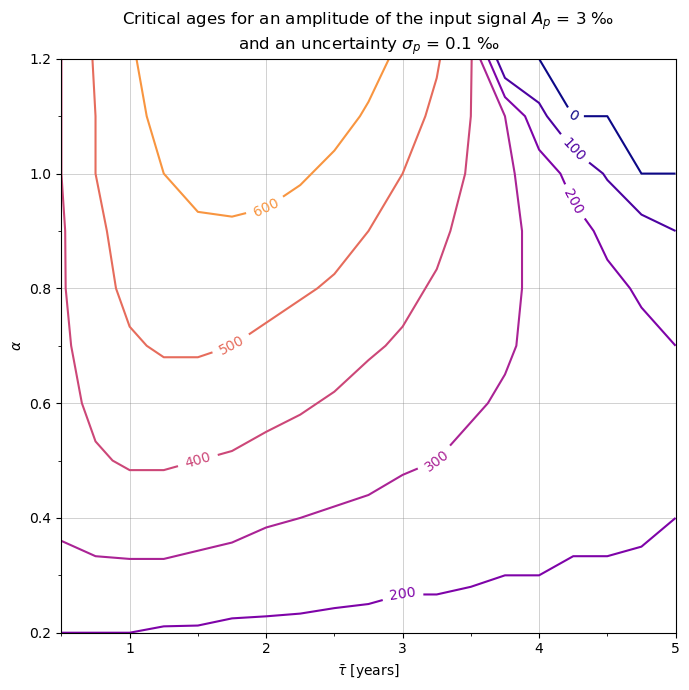

In [7]:
fig, ax = plt.subplots(figsize=(7,7))

# Define colormap and contour levels
cmap_ca = cm.plasma  

min_val = 0
max_val = int(
    max(np.max(critical_age), np.max(critical_age))
    // 100 * 100 + 100
)
levels = np.linspace(0, max_val, max_val // 100 + 1)  # Define levels every 100 days, adjust as needed

# Add vertical and horizontal lines
for j in range(4):
    ax.hlines(y=0.4 + j*0.2, xmin=.5, xmax=5, colors='gray', linewidth=.5, alpha=.5)
    ax.vlines(x=1 + j, ymin=.2, ymax=1.2, colors='gray', linewidth=.5, alpha=.5)

# Plot critical age contours
CS1 = ax.contour(tau_bar / num_days_in_year, alpha, critical_age, levels=levels, cmap=cmap_ca)
ax.clabel(CS1, inline=True, fontsize=10)

# Graph elements
tick_positions_x = [1, 2, 3, 4, 5]  # tau bar (MTT) ticks
ax.set_xticks(tick_positions_x)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))

tick_positions_y = [.2, .4, .6, .8, 1, 1.2]  # alpha ticks
ax.set_yticks(tick_positions_y)
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

ax.set_xlabel(r'$\bar{\tau}$ [years]')
ax.set_ylabel(r'$\alpha$')

ax.set_title(r"Critical ages for an amplitude of the input signal " + f"$A_p$ = {A_p} ‰\n" + r"and an uncertainty $\sigma_{p}$ = " + f"{sigma_p} ‰")

fig.tight_layout()